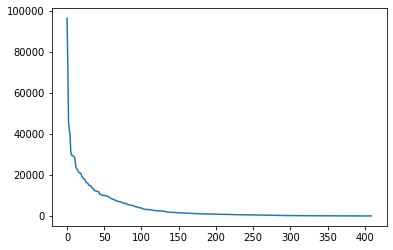

In [1]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import itertools
import collections
import matplotlib.pyplot as plt

# Read in data
df = pd.read_csv("English_Cn_Name_Corpus（48W）.txt", header=None, names=["name"], skiprows=2)
names = df["name"].values

# Compute character frequency
chars = [list(name) for name in names]
chars_flatten = list(itertools.chain(*chars))
freq = collections.Counter(chars_flatten)
freq = pd.DataFrame(freq.items(), columns=["char", "freq"])
freq = freq.sort_values(by="freq", ascending=False)

# Frequency distribution
char_rank = np.arange(freq.shape[0])
char_freq = freq["freq"].values
plt.plot(char_rank, char_freq)

In [3]:
# Prepare data
dict_size = 50
charset_size = dict_size + 1  # for EOS
dict = list(freq["char"].values[:dict_size])
dict_set = set(dict)
dat = list(filter(lambda name: set(name).issubset(dict_set), names))

# One-hot encoding
def char2index(char):
    return dict.index(char)

def name2index(name):
    return [char2index(char) for char in name]

def char2tensor(char):
    tensor = torch.zeros(1, charset_size)
    tensor[0, char2index(char)] = 1
    return tensor

def name2tensor(name):
    tensor = torch.zeros(len(name), 1, charset_size)
    for i, char in enumerate(name):
        tensor[i, 0, char2index(char)] = 1
    return tensor

def names2tensor(names):
    n = len(names)
    lens = [len(name) for name in names]
    max_len = np.max(lens)
    tensor = torch.zeros(max_len, n, charset_size)
    target = torch.zeros(max_len, n, dtype=int) + charset_size - 1
    for i in range(n):
        name = names[i]             # the i-th name
        for j in range(len(name)):  # the j-th character in the name
            tensor[j, i, char2index(name[j])] = 1
            if j < len(name) - 1:
                target[j, i] = char2index(name[j + 1])
    return tensor, np.array(lens), target

char2index("斯")

1

In [7]:
name2index("斯基")

[1, 17]

In [9]:
char2tensor("斯")

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
name2tensor("斯基")

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [12]:
names2tensor(["斯基", "斯诺夫"])

(tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0.,

In [14]:
# Build model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, input_size)
        self.o2o = nn.Linear(hidden_size + input_size, input_size)
        self.dropout = nn.Dropout(0.1)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = torch.relu(self.i2h(input_combined))
        output = torch.relu(self.i2o(input_combined))
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.logsoftmax(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [20]:
n_hidden = 64
rnn = RNN(charset_size, n_hidden)
input = name2tensor("斯基")
hidden = rnn.init_hidden(batch_size=1)
output, next_hidden = rnn(input[0], hidden)
output

tensor([[-3.9285, -3.9483, -4.0047, -3.8546, -3.9290, -3.8550, -4.0007, -3.9343,
         -3.8665, -3.8373, -3.9946, -4.0264, -3.9087, -4.0209, -3.9290, -3.9034,
         -3.9888, -3.8718, -3.9290, -3.8218, -3.9290, -3.9596, -3.9290, -3.9062,
         -3.9237, -3.9429, -3.9491, -3.9066, -3.9202, -4.0143, -3.8407, -3.8687,
         -3.9293, -4.0459, -3.9319, -4.0004, -3.8999, -3.8910, -3.9484, -3.9278,
         -3.9379, -3.8882, -3.9789, -3.9738, -4.0340, -4.0063, -3.8449, -3.9975,
         -3.8641, -3.9290, -3.9290]], grad_fn=<LogSoftmaxBackward0>)

epoch 0, batch 0, loss = 3.9328794479370117
epoch 0, batch 10, loss = 3.537919521331787
epoch 0, batch 20, loss = 3.2228903770446777
epoch 0, batch 30, loss = 3.178758382797241
epoch 0, batch 40, loss = 3.1477208137512207
epoch 0, batch 50, loss = 3.12373948097229
epoch 0, batch 60, loss = 3.138552188873291
epoch 0, batch 70, loss = 3.149634838104248
epoch 0, batch 80, loss = 3.134317398071289
epoch 0, batch 90, loss = 3.1014957427978516
epoch 0, batch 100, loss = 3.089360237121582
epoch 0, batch 110, loss = 3.09610915184021
epoch 0, batch 120, loss = 3.074462652206421
epoch 0, batch 130, loss = 3.0096940994262695
epoch 0, batch 140, loss = 3.0294103622436523
epoch 0, batch 150, loss = 3.0045087337493896
epoch 0, batch 160, loss = 3.027930974960327
epoch 0, batch 170, loss = 3.004671573638916
epoch 0, batch 180, loss = 2.9816555976867676
epoch 0, batch 190, loss = 2.985799789428711
epoch 0, batch 200, loss = 2.9343924522399902
epoch 0, batch 210, loss = 2.935732364654541
epoch 0, batch

epoch 6, batch 80, loss = 2.7369813919067383
epoch 6, batch 90, loss = 2.8137803077697754
epoch 6, batch 100, loss = 2.7927467823028564
epoch 6, batch 110, loss = 2.7195167541503906
epoch 6, batch 120, loss = 2.800140142440796
epoch 6, batch 130, loss = 2.7990827560424805
epoch 6, batch 140, loss = 2.7827084064483643
epoch 6, batch 150, loss = 2.8155226707458496
epoch 6, batch 160, loss = 2.812436580657959
epoch 6, batch 170, loss = 2.8359124660491943
epoch 6, batch 180, loss = 2.754267692565918
epoch 6, batch 190, loss = 2.7674026489257812
epoch 6, batch 200, loss = 2.815617561340332
epoch 6, batch 210, loss = 2.871051073074341
epoch 6, batch 220, loss = 2.7906219959259033
epoch 6, batch 230, loss = 2.814743757247925
epoch 6, batch 240, loss = 2.7548346519470215
epoch 6, batch 250, loss = 2.77679443359375
epoch 6, batch 260, loss = 2.8081612586975098
epoch 6, batch 270, loss = 2.791797399520874
epoch 6, batch 280, loss = 2.7720754146575928
epoch 7, batch 0, loss = 2.8001465797424316
e

epoch 12, batch 140, loss = 2.7972207069396973
epoch 12, batch 150, loss = 2.7739524841308594
epoch 12, batch 160, loss = 2.74686336517334
epoch 12, batch 170, loss = 2.785212993621826
epoch 12, batch 180, loss = 2.7305870056152344
epoch 12, batch 190, loss = 2.7801623344421387
epoch 12, batch 200, loss = 2.7597057819366455
epoch 12, batch 210, loss = 2.7491650581359863
epoch 12, batch 220, loss = 2.741611957550049
epoch 12, batch 230, loss = 2.774434804916382
epoch 12, batch 240, loss = 2.7018940448760986
epoch 12, batch 250, loss = 2.722454071044922
epoch 12, batch 260, loss = 2.75022029876709
epoch 12, batch 270, loss = 2.738976001739502
epoch 12, batch 280, loss = 2.76480770111084
epoch 13, batch 0, loss = 2.724917411804199
epoch 13, batch 10, loss = 2.6741912364959717
epoch 13, batch 20, loss = 2.72467041015625
epoch 13, batch 30, loss = 2.7443814277648926
epoch 13, batch 40, loss = 2.7301759719848633
epoch 13, batch 50, loss = 2.725569009780884
epoch 13, batch 60, loss = 2.733960

epoch 18, batch 180, loss = 2.7480926513671875
epoch 18, batch 190, loss = 2.723600387573242
epoch 18, batch 200, loss = 2.753852367401123
epoch 18, batch 210, loss = 2.7232367992401123
epoch 18, batch 220, loss = 2.7316009998321533
epoch 18, batch 230, loss = 2.7850632667541504
epoch 18, batch 240, loss = 2.789623737335205
epoch 18, batch 250, loss = 2.7171683311462402
epoch 18, batch 260, loss = 2.716533660888672
epoch 18, batch 270, loss = 2.737255573272705
epoch 18, batch 280, loss = 2.70350980758667
epoch 19, batch 0, loss = 2.7614638805389404
epoch 19, batch 10, loss = 2.695120334625244
epoch 19, batch 20, loss = 2.6845240592956543
epoch 19, batch 30, loss = 2.708112955093384
epoch 19, batch 40, loss = 2.7215185165405273
epoch 19, batch 50, loss = 2.695143699645996
epoch 19, batch 60, loss = 2.7312116622924805
epoch 19, batch 70, loss = 2.739257335662842
epoch 19, batch 80, loss = 2.7039599418640137
epoch 19, batch 90, loss = 2.745323657989502
epoch 19, batch 100, loss = 2.694930

epoch 24, batch 220, loss = 2.7113983631134033
epoch 24, batch 230, loss = 2.7188918590545654
epoch 24, batch 240, loss = 2.657975196838379
epoch 24, batch 250, loss = 2.7097601890563965
epoch 24, batch 260, loss = 2.7349071502685547
epoch 24, batch 270, loss = 2.7033472061157227
epoch 24, batch 280, loss = 2.6796092987060547
epoch 25, batch 0, loss = 2.698425054550171
epoch 25, batch 10, loss = 2.6938722133636475
epoch 25, batch 20, loss = 2.7110228538513184
epoch 25, batch 30, loss = 2.7136070728302
epoch 25, batch 40, loss = 2.690182685852051
epoch 25, batch 50, loss = 2.685260057449341
epoch 25, batch 60, loss = 2.6539573669433594
epoch 25, batch 70, loss = 2.673510789871216
epoch 25, batch 80, loss = 2.7387423515319824
epoch 25, batch 90, loss = 2.739482879638672
epoch 25, batch 100, loss = 2.701543092727661
epoch 25, batch 110, loss = 2.6887338161468506
epoch 25, batch 120, loss = 2.6862292289733887
epoch 25, batch 130, loss = 2.67356014251709
epoch 25, batch 140, loss = 2.753395

epoch 30, batch 260, loss = 2.6763904094696045
epoch 30, batch 270, loss = 2.6720972061157227
epoch 30, batch 280, loss = 2.698326826095581
epoch 31, batch 0, loss = 2.644132614135742
epoch 31, batch 10, loss = 2.70188570022583
epoch 31, batch 20, loss = 2.6432437896728516
epoch 31, batch 30, loss = 2.678601026535034
epoch 31, batch 40, loss = 2.6643874645233154
epoch 31, batch 50, loss = 2.6753225326538086
epoch 31, batch 60, loss = 2.699669122695923
epoch 31, batch 70, loss = 2.7036943435668945
epoch 31, batch 80, loss = 2.71893310546875
epoch 31, batch 90, loss = 2.705899477005005
epoch 31, batch 100, loss = 2.684706687927246
epoch 31, batch 110, loss = 2.699069023132324
epoch 31, batch 120, loss = 2.766448736190796
epoch 31, batch 130, loss = 2.711073637008667
epoch 31, batch 140, loss = 2.6798813343048096
epoch 31, batch 150, loss = 2.6906793117523193
epoch 31, batch 160, loss = 2.697939872741699
epoch 31, batch 170, loss = 2.6719377040863037
epoch 31, batch 180, loss = 2.71064996

epoch 37, batch 10, loss = 2.6304686069488525
epoch 37, batch 20, loss = 2.5988481044769287
epoch 37, batch 30, loss = 2.634349822998047
epoch 37, batch 40, loss = 2.6439127922058105
epoch 37, batch 50, loss = 2.649951457977295
epoch 37, batch 60, loss = 2.654613494873047
epoch 37, batch 70, loss = 2.672102928161621
epoch 37, batch 80, loss = 2.6809167861938477
epoch 37, batch 90, loss = 2.6461551189422607
epoch 37, batch 100, loss = 2.7385711669921875
epoch 37, batch 110, loss = 2.606367588043213
epoch 37, batch 120, loss = 2.721500873565674
epoch 37, batch 130, loss = 2.666260242462158
epoch 37, batch 140, loss = 2.6714365482330322
epoch 37, batch 150, loss = 2.6855647563934326
epoch 37, batch 160, loss = 2.688079357147217
epoch 37, batch 170, loss = 2.654271125793457
epoch 37, batch 180, loss = 2.6439356803894043
epoch 37, batch 190, loss = 2.6579465866088867
epoch 37, batch 200, loss = 2.7026515007019043
epoch 37, batch 210, loss = 2.706042528152466
epoch 37, batch 220, loss = 2.66

epoch 43, batch 50, loss = 2.617619752883911
epoch 43, batch 60, loss = 2.6732892990112305
epoch 43, batch 70, loss = 2.6667332649230957
epoch 43, batch 80, loss = 2.6714248657226562
epoch 43, batch 90, loss = 2.582911491394043
epoch 43, batch 100, loss = 2.6016368865966797
epoch 43, batch 110, loss = 2.686519145965576
epoch 43, batch 120, loss = 2.6707141399383545
epoch 43, batch 130, loss = 2.6458940505981445
epoch 43, batch 140, loss = 2.6745386123657227
epoch 43, batch 150, loss = 2.6498632431030273
epoch 43, batch 160, loss = 2.6638269424438477
epoch 43, batch 170, loss = 2.679373025894165
epoch 43, batch 180, loss = 2.6831064224243164
epoch 43, batch 190, loss = 2.6261980533599854
epoch 43, batch 200, loss = 2.659148931503296
epoch 43, batch 210, loss = 2.670079469680786
epoch 43, batch 220, loss = 2.7297470569610596
epoch 43, batch 230, loss = 2.6851930618286133
epoch 43, batch 240, loss = 2.714975357055664
epoch 43, batch 250, loss = 2.6126222610473633
epoch 43, batch 260, loss

epoch 49, batch 90, loss = 2.6778724193573
epoch 49, batch 100, loss = 2.662787914276123
epoch 49, batch 110, loss = 2.6274619102478027
epoch 49, batch 120, loss = 2.6271114349365234
epoch 49, batch 130, loss = 2.6812620162963867
epoch 49, batch 140, loss = 2.6520252227783203
epoch 49, batch 150, loss = 2.630413293838501
epoch 49, batch 160, loss = 2.6454315185546875
epoch 49, batch 170, loss = 2.677338123321533
epoch 49, batch 180, loss = 2.6869921684265137
epoch 49, batch 190, loss = 2.6586198806762695
epoch 49, batch 200, loss = 2.667084217071533
epoch 49, batch 210, loss = 2.658641815185547
epoch 49, batch 220, loss = 2.6651530265808105
epoch 49, batch 230, loss = 2.6425557136535645
epoch 49, batch 240, loss = 2.60209321975708
epoch 49, batch 250, loss = 2.6813621520996094
epoch 49, batch 260, loss = 2.701512098312378
epoch 49, batch 270, loss = 2.637747287750244
epoch 49, batch 280, loss = 2.6903929710388184
epoch 50, batch 0, loss = 2.6270859241485596
epoch 50, batch 10, loss = 2

epoch 55, batch 130, loss = 2.633399486541748
epoch 55, batch 140, loss = 2.6352198123931885
epoch 55, batch 150, loss = 2.6322145462036133
epoch 55, batch 160, loss = 2.63820219039917
epoch 55, batch 170, loss = 2.627930164337158
epoch 55, batch 180, loss = 2.5845580101013184
epoch 55, batch 190, loss = 2.618638277053833
epoch 55, batch 200, loss = 2.5885426998138428
epoch 55, batch 210, loss = 2.5793678760528564
epoch 55, batch 220, loss = 2.6750149726867676
epoch 55, batch 230, loss = 2.59545636177063
epoch 55, batch 240, loss = 2.612649917602539
epoch 55, batch 250, loss = 2.6173295974731445
epoch 55, batch 260, loss = 2.6315579414367676
epoch 55, batch 270, loss = 2.6552090644836426
epoch 55, batch 280, loss = 2.6013236045837402
epoch 56, batch 0, loss = 2.59818172454834
epoch 56, batch 10, loss = 2.6844143867492676
epoch 56, batch 20, loss = 2.607532024383545
epoch 56, batch 30, loss = 2.5524234771728516
epoch 56, batch 40, loss = 2.5955557823181152
epoch 56, batch 50, loss = 2.6

epoch 61, batch 170, loss = 2.597409725189209
epoch 61, batch 180, loss = 2.6466546058654785
epoch 61, batch 190, loss = 2.6272425651550293
epoch 61, batch 200, loss = 2.6566250324249268
epoch 61, batch 210, loss = 2.645073175430298
epoch 61, batch 220, loss = 2.629546642303467
epoch 61, batch 230, loss = 2.64880108833313
epoch 61, batch 240, loss = 2.6505348682403564
epoch 61, batch 250, loss = 2.609429359436035
epoch 61, batch 260, loss = 2.5754780769348145
epoch 61, batch 270, loss = 2.6433138847351074
epoch 61, batch 280, loss = 2.603105306625366
epoch 62, batch 0, loss = 2.58305025100708
epoch 62, batch 10, loss = 2.594888687133789
epoch 62, batch 20, loss = 2.599020481109619
epoch 62, batch 30, loss = 2.6328182220458984
epoch 62, batch 40, loss = 2.604985237121582
epoch 62, batch 50, loss = 2.5794005393981934
epoch 62, batch 60, loss = 2.5963215827941895
epoch 62, batch 70, loss = 2.6031298637390137
epoch 62, batch 80, loss = 2.624791383743286
epoch 62, batch 90, loss = 2.5921838

epoch 67, batch 210, loss = 2.575788974761963
epoch 67, batch 220, loss = 2.6002461910247803
epoch 67, batch 230, loss = 2.612118721008301
epoch 67, batch 240, loss = 2.639622688293457
epoch 67, batch 250, loss = 2.6256051063537598
epoch 67, batch 260, loss = 2.6217329502105713
epoch 67, batch 270, loss = 2.616360664367676
epoch 67, batch 280, loss = 2.6667351722717285
epoch 68, batch 0, loss = 2.5559730529785156
epoch 68, batch 10, loss = 2.575460433959961
epoch 68, batch 20, loss = 2.5783238410949707
epoch 68, batch 30, loss = 2.559950351715088
epoch 68, batch 40, loss = 2.636035919189453
epoch 68, batch 50, loss = 2.6266794204711914
epoch 68, batch 60, loss = 2.596083641052246
epoch 68, batch 70, loss = 2.577479839324951
epoch 68, batch 80, loss = 2.5950422286987305
epoch 68, batch 90, loss = 2.6158242225646973
epoch 68, batch 100, loss = 2.616316795349121
epoch 68, batch 110, loss = 2.596784830093384
epoch 68, batch 120, loss = 2.5488505363464355
epoch 68, batch 130, loss = 2.62349

epoch 73, batch 250, loss = 2.6157541275024414
epoch 73, batch 260, loss = 2.587563991546631
epoch 73, batch 270, loss = 2.573687791824341
epoch 73, batch 280, loss = 2.5896780490875244
epoch 74, batch 0, loss = 2.6044416427612305
epoch 74, batch 10, loss = 2.6132054328918457
epoch 74, batch 20, loss = 2.571786880493164
epoch 74, batch 30, loss = 2.55155086517334
epoch 74, batch 40, loss = 2.6119771003723145
epoch 74, batch 50, loss = 2.589992046356201
epoch 74, batch 60, loss = 2.561224937438965
epoch 74, batch 70, loss = 2.6103906631469727
epoch 74, batch 80, loss = 2.6057443618774414
epoch 74, batch 90, loss = 2.6300885677337646
epoch 74, batch 100, loss = 2.5709755420684814
epoch 74, batch 110, loss = 2.644111156463623
epoch 74, batch 120, loss = 2.629045248031616
epoch 74, batch 130, loss = 2.570223331451416
epoch 74, batch 140, loss = 2.6039175987243652
epoch 74, batch 150, loss = 2.579272747039795
epoch 74, batch 160, loss = 2.572274923324585
epoch 74, batch 170, loss = 2.590011

epoch 80, batch 10, loss = 2.5749611854553223
epoch 80, batch 20, loss = 2.6170549392700195
epoch 80, batch 30, loss = 2.621377468109131
epoch 80, batch 40, loss = 2.5529112815856934
epoch 80, batch 50, loss = 2.5889315605163574
epoch 80, batch 60, loss = 2.5326218605041504
epoch 80, batch 70, loss = 2.6035096645355225
epoch 80, batch 80, loss = 2.6351656913757324
epoch 80, batch 90, loss = 2.585247755050659
epoch 80, batch 100, loss = 2.623727798461914
epoch 80, batch 110, loss = 2.5746917724609375
epoch 80, batch 120, loss = 2.5714943408966064
epoch 80, batch 130, loss = 2.5375638008117676
epoch 80, batch 140, loss = 2.624922752380371
epoch 80, batch 150, loss = 2.63155460357666
epoch 80, batch 160, loss = 2.5966367721557617
epoch 80, batch 170, loss = 2.582953691482544
epoch 80, batch 180, loss = 2.5720772743225098
epoch 80, batch 190, loss = 2.6280834674835205
epoch 80, batch 200, loss = 2.6077373027801514
epoch 80, batch 210, loss = 2.5922603607177734
epoch 80, batch 220, loss = 2

epoch 86, batch 50, loss = 2.631929874420166
epoch 86, batch 60, loss = 2.5798871517181396
epoch 86, batch 70, loss = 2.5635030269622803
epoch 86, batch 80, loss = 2.6253600120544434
epoch 86, batch 90, loss = 2.607145071029663
epoch 86, batch 100, loss = 2.6044228076934814
epoch 86, batch 110, loss = 2.5859761238098145
epoch 86, batch 120, loss = 2.5702085494995117
epoch 86, batch 130, loss = 2.5926764011383057
epoch 86, batch 140, loss = 2.5595946311950684
epoch 86, batch 150, loss = 2.5743308067321777
epoch 86, batch 160, loss = 2.6143975257873535
epoch 86, batch 170, loss = 2.5412049293518066
epoch 86, batch 180, loss = 2.605106830596924
epoch 86, batch 190, loss = 2.617239236831665
epoch 86, batch 200, loss = 2.5923125743865967
epoch 86, batch 210, loss = 2.6229655742645264
epoch 86, batch 220, loss = 2.549927234649658
epoch 86, batch 230, loss = 2.6535186767578125
epoch 86, batch 240, loss = 2.5878348350524902
epoch 86, batch 250, loss = 2.627774715423584
epoch 86, batch 260, los

epoch 92, batch 90, loss = 2.5927858352661133
epoch 92, batch 100, loss = 2.634700298309326
epoch 92, batch 110, loss = 2.545477867126465
epoch 92, batch 120, loss = 2.6214194297790527
epoch 92, batch 130, loss = 2.6324872970581055
epoch 92, batch 140, loss = 2.597238063812256
epoch 92, batch 150, loss = 2.6407155990600586
epoch 92, batch 160, loss = 2.607081413269043
epoch 92, batch 170, loss = 2.635141372680664
epoch 92, batch 180, loss = 2.6108622550964355
epoch 92, batch 190, loss = 2.609954357147217
epoch 92, batch 200, loss = 2.6074795722961426
epoch 92, batch 210, loss = 2.6018331050872803
epoch 92, batch 220, loss = 2.61002779006958
epoch 92, batch 230, loss = 2.6008191108703613
epoch 92, batch 240, loss = 2.5727522373199463
epoch 92, batch 250, loss = 2.5842831134796143
epoch 92, batch 260, loss = 2.5560665130615234
epoch 92, batch 270, loss = 2.574601650238037
epoch 92, batch 280, loss = 2.564213275909424
epoch 93, batch 0, loss = 2.5671896934509277
epoch 93, batch 10, loss =

epoch 98, batch 130, loss = 2.5812244415283203
epoch 98, batch 140, loss = 2.6138205528259277
epoch 98, batch 150, loss = 2.6346042156219482
epoch 98, batch 160, loss = 2.5827860832214355
epoch 98, batch 170, loss = 2.6426639556884766
epoch 98, batch 180, loss = 2.5460586547851562
epoch 98, batch 190, loss = 2.5762939453125
epoch 98, batch 200, loss = 2.592587947845459
epoch 98, batch 210, loss = 2.5769104957580566
epoch 98, batch 220, loss = 2.588428020477295
epoch 98, batch 230, loss = 2.588514566421509
epoch 98, batch 240, loss = 2.569443464279175
epoch 98, batch 250, loss = 2.6090621948242188
epoch 98, batch 260, loss = 2.6080105304718018
epoch 98, batch 270, loss = 2.6114678382873535
epoch 98, batch 280, loss = 2.5581717491149902
epoch 99, batch 0, loss = 2.533545970916748
epoch 99, batch 10, loss = 2.5092971324920654
epoch 99, batch 20, loss = 2.562070369720459
epoch 99, batch 30, loss = 2.5905275344848633
epoch 99, batch 40, loss = 2.575561285018921
epoch 99, batch 50, loss = 2.

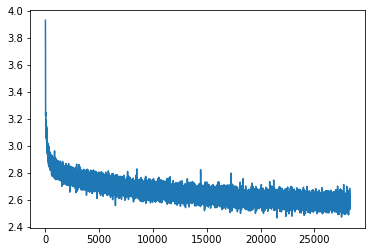

In [16]:
np.random.seed(123)
torch.random.manual_seed(123)
device = torch.device("cuda")
# device = torch.device("cpu")  # If no GPU on the machine

# train_id = np.random.choice(len(dat), 10000)
# train = [dat[i] for i in train_id]
train = dat

n = len(train)
n_hidden = 256
nepoch = 100
bs = 256

rnn = RNN(charset_size, n_hidden)
rnn = rnn.to(device=device)
opt = torch.optim.Adam(rnn.parameters(), lr=0.001)
train_ind = np.arange(n)
lossfn = nn.NLLLoss(reduction="none")
losses = []

t1 = time.time()
for k in range(nepoch):
    np.random.shuffle(train_ind)
    # Update on mini-batches
    for j in range(0, n, bs):
        # Create mini-batch
        ind = train_ind[j:(j + bs)]
        mb = [train[i] for i in ind]
        mb_size = len(mb)
        input, actual_len, target = names2tensor(mb)
        input = input.to(device=device)
        target = target.to(device=device)
        max_len = input.shape[0]
        hidden = rnn.init_hidden(mb_size).to(device=device)
        loss = 0.0
        for s in range(max_len):
            output, hidden = rnn(input[s], hidden)
            loss_s = lossfn(output, target[s])
            valid = torch.tensor((s < actual_len).astype(int)).to(device=device)
            loss = loss + loss_s * valid
        loss = torch.mean(loss / torch.tensor(actual_len).to(device=device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if j // bs % 10 == 0:
            print(f"epoch {k}, batch {j // bs}, loss = {loss.item()}")
t2 = time.time()
print(t2 - t1)
plt.plot(losses)

In [17]:
# torch.save(rnn.state_dict(), "gen_en.pt")
rnn.load_state_dict(torch.load("gen_en.pt", map_location=device))
rnn.eval()

RNN(
  (i2h): Linear(in_features=307, out_features=256, bias=True)
  (i2o): Linear(in_features=307, out_features=51, bias=True)
  (o2o): Linear(in_features=307, out_features=51, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (logsoftmax): LogSoftmax(dim=1)
)

In [18]:
family_names = np.unique([name[0] for name in dat])
def random_family_name():
    return np.random.choice(family_names, 1)[0]

def random_name(max_len=4):
    rnn.eval()
    family_name = random_family_name()
    input = char2tensor(family_name).to(device=device)
    char_ind = [torch.argmax(input).item()]
    hidden = rnn.init_hidden(batch_size=1).to(device=device)
    for i in range(max_len - 1):
        output, hidden = rnn(input, hidden)
        ind = torch.argmax(output).item()
        if ind == charset_size - 1:
            break
        char_ind.append(ind)
        input.zero_()
        input[0, ind] = 1.0
    return char_ind

np.random.seed(123)
torch.random.manual_seed(123)
ind = random_name(10)
print("".join([dict[i] for i in ind]))

雷斯塔


In [19]:
np.random.seed(123)
torch.random.manual_seed(123)
names = []
for i in range(50):
    ind = random_name(10)
    names.append("".join([dict[i] for i in ind]))
np.set_printoptions(linewidth=50)
print(np.array(names))

['雷斯塔' '伊尔马斯' '瓦尔德' '耶尔维' '西尔韦斯特里' '布拉伊科夫斯基'
 '库尔蒂耶' '迪亚科' '拉斯特里' '罗斯托' '维尔斯' '马尔基奥' '埃斯特拉德'
 '维尔斯' '韦尔尼' '维尔斯' '马尔基奥' '格拉斯科' '库尔蒂耶' '尔德'
 '萨尔瓦尼' '维尔斯' '巴尔巴里尼' '内斯托拉' '克拉斯尼奇' '伊尔马斯'
 '德拉斯科' '诺尔贝格' '伊尔马斯' '德拉斯科' '马尔基奥' '勒布罗' '达尔马斯'
 '莱斯科' '瓦尔德' '西尔韦斯特里' '罗斯托' '托尔托拉' '米尔科' '特里斯塔尼'
 '耶尔维' '罗斯托' '奇科' '贝尔托利尼' '克拉斯尼奇' '迪亚科' '利亚尔迪'
 '亚尔马' '塔尔迪' '耶尔维']
